### Шарафетдинов Ринат Саярович

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")

In [2]:
data1 = pd.read_csv('data_01.csv')
data2 = pd.read_csv('data_02.csv')
data3 = pd.read_csv('data_03.csv')
data4 = pd.read_csv('data_04.csv')
data5 = pd.read_csv('data_05.csv')
data6 = pd.read_csv('data_06.csv')

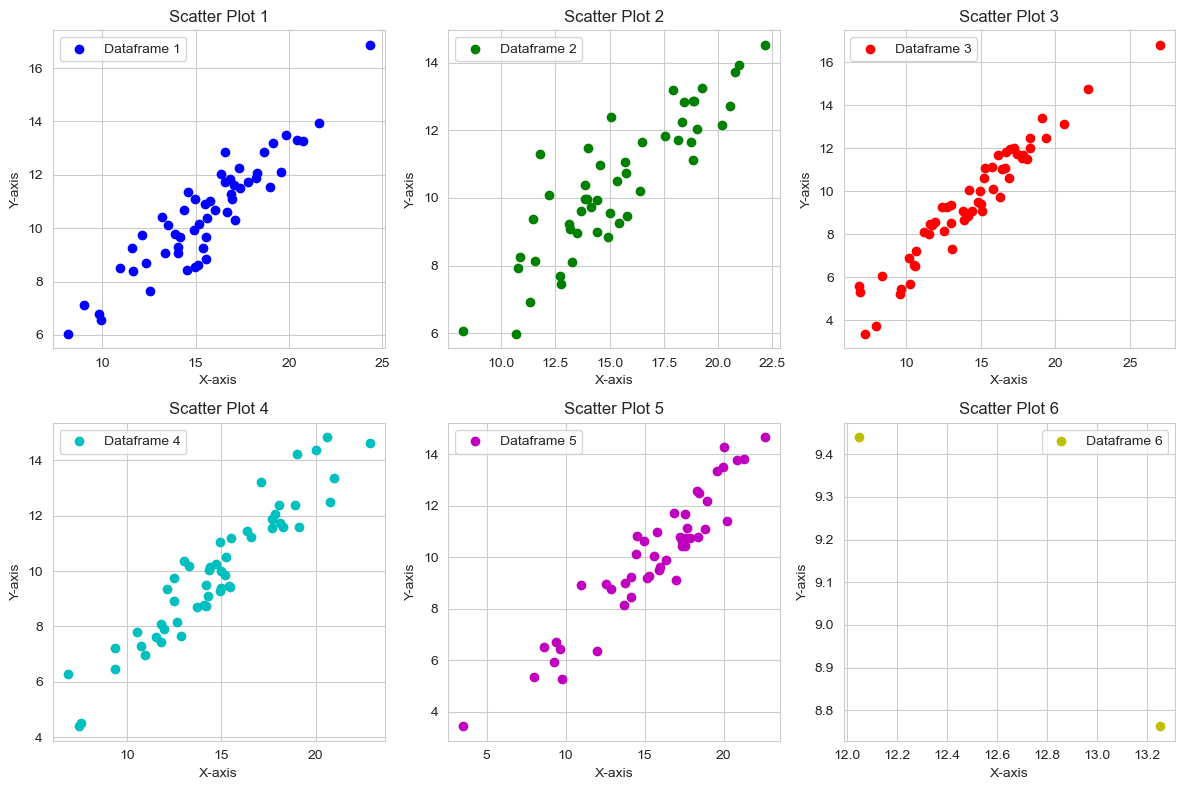

In [3]:
import matplotlib.pyplot as plt

# Assuming you have six dataframes: df1, df2, df3, df4, df5, df6
dataframes = [data1, data2, data3, data4, data5, data6]

# Create a list of colors for the plots
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Create six separate scatter plots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, df in enumerate(dataframes):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    ax.scatter(df['x'], df['y'], label=f'Dataframe {i + 1}', color=colors[i])
    ax.set_title(f'Scatter Plot {i + 1}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [4]:
def remove_outliers_iqr(df, column, lower_bound=0.25, upper_bound=0.75):
    Q1 = df[column].quantile(lower_bound)
    Q3 = df[column].quantile(upper_bound)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
    return df_filtered

# Указать столбцы, из которых вы хотите удалить выбросы
columns_to_remove_outliers = ['x', 'y']

for column in columns_to_remove_outliers:
    df1_no_outliers = remove_outliers_iqr(data1, column)

for column in columns_to_remove_outliers:
    df2_no_outliers = remove_outliers_iqr(data2, column)

for column in columns_to_remove_outliers:
    df3_no_outliers = remove_outliers_iqr(data3, column)

for column in columns_to_remove_outliers:
    df4_no_outliers = remove_outliers_iqr(data4, column)

for column in columns_to_remove_outliers:
    df5_no_outliers = remove_outliers_iqr(data5, column)

for column in columns_to_remove_outliers:
    df6_no_outliers = remove_outliers_iqr(data6, column)


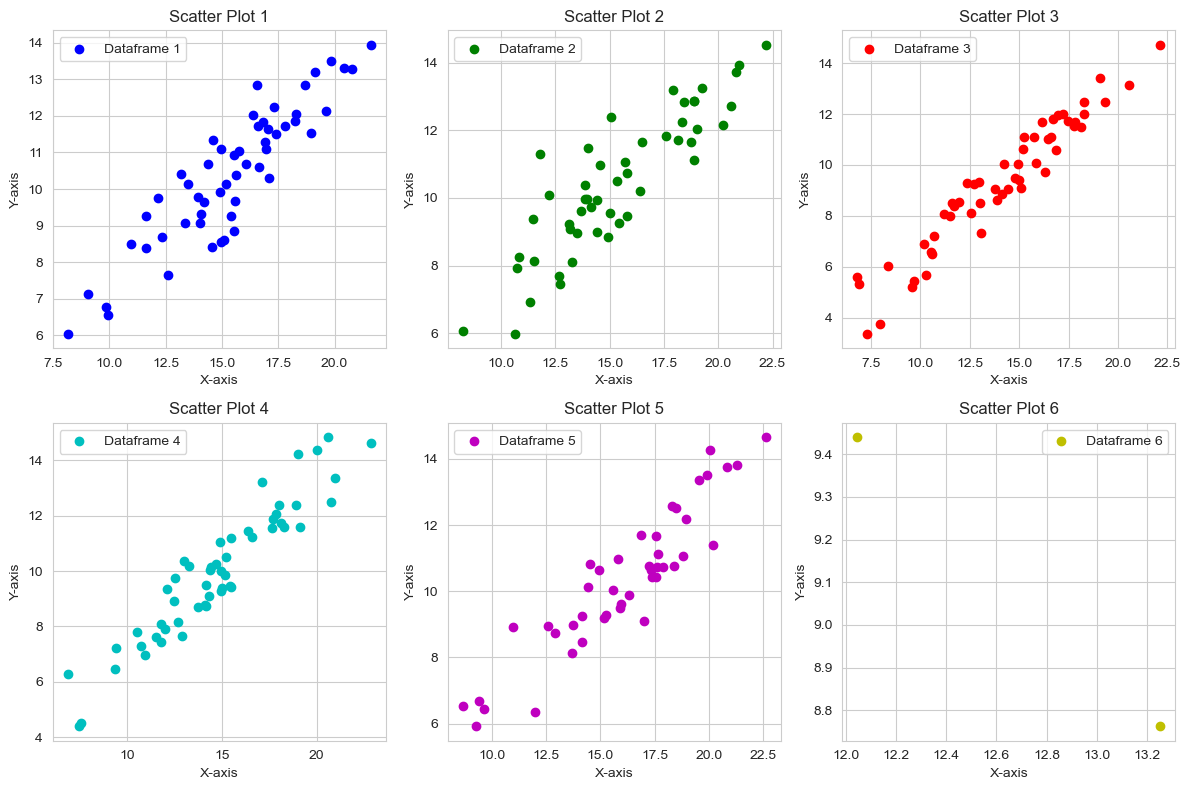

In [5]:
# Assuming you have six dataframes: df1, df2, df3, df4, df5, df6
dataframes_no_outliers = [df1_no_outliers, df2_no_outliers, df3_no_outliers, df4_no_outliers, df5_no_outliers, df6_no_outliers]

# Create a list of colors for the plots
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Create six separate scatter plots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, df in enumerate(dataframes_no_outliers):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    ax.scatter(df['x'], df['y'], label=f'Dataframe {i + 1}', color=colors[i])
    ax.set_title(f'Scatter Plot {i + 1}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [6]:
all_data = pd.concat(dataframes_no_outliers, keys=range(len(dataframes_no_outliers)))

all_data['dataset_idx'] = np.repeat(range(len(dataframes_no_outliers)), [len(df) for df in dataframes_no_outliers])

In [7]:
all_data['x'] = all_data['x'] - all_data['x'].mean()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 600 draw iterations (3_000 + 1_800 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


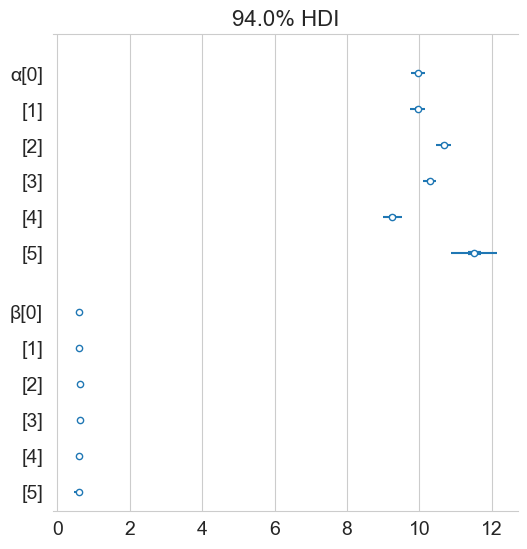

In [8]:
with pm.Model() as hierarchical_model:
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=4.2)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=2)
    β_μ = pm.Normal('β_μ', mu=0, sigma=2)
    β_σ = pm.HalfNormal('β_σ', sigma=2)

    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=len(dataframes_no_outliers))
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=len(dataframes_no_outliers))
    ε = pm.HalfCauchy('ε', 2)
    ν = pm.Normal('ν', 1/15)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[all_data['dataset_idx']] + β[all_data['dataset_idx']] * all_data['x'].values,
                         sigma=ε, nu=ν, observed=all_data['y'].values)

    α = pm.Deterministic('α', α_tmp - β * all_data.groupby('dataset_idx').mean()['x'].values)
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * all_data.groupby('dataset_idx').mean()['x'].values)
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * all_data.groupby('dataset_idx').mean()['x'].values)

    trace_hm = pm.sample(600, target_accept=0.95)

# Отобразите результаты
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

In [9]:
az.summary(trace_hm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_μ_tmp,10.057,0.133,9.838,10.316,0.005,0.003,960.0,652.0,1.00
β_μ,0.605,0.032,0.544,0.664,0.001,0.001,680.0,572.0,1.01
α_tmp[0],10.177,0.104,9.981,10.370,0.003,0.002,1008.0,1266.0,1.00
α_tmp[1],10.154,0.113,9.941,10.357,0.004,0.003,995.0,1134.0,1.00
α_tmp[2],10.018,0.102,9.829,10.214,0.003,0.002,1305.0,1025.0,1.00
α_tmp[3],10.068,0.098,9.873,10.244,0.002,0.002,1654.0,1213.0,1.00
α_tmp[4],9.851,0.138,9.611,10.102,0.005,0.004,698.0,891.0,1.00
α_tmp[5],10.106,0.250,9.637,10.600,0.007,0.005,1254.0,1107.0,1.01
β[0],0.588,0.030,0.536,0.645,0.003,0.002,106.0,167.0,1.03
β[1],0.596,0.030,0.538,0.647,0.002,0.001,308.0,997.0,1.02


array([[<Axes: title={'center': 'α_μ_tmp'}>,
        <Axes: title={'center': 'α_μ_tmp'}>],
       [<Axes: title={'center': 'β_μ'}>, <Axes: title={'center': 'β_μ'}>],
       [<Axes: title={'center': 'α_tmp'}>,
        <Axes: title={'center': 'α_tmp'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'α_σ_tmp'}>,
        <Axes: title={'center': 'α_σ_tmp'}>],
       [<Axes: title={'center': 'β_σ'}>, <Axes: title={'center': 'β_σ'}>],
       [<Axes: title={'center': 'ε'}>, <Axes: title={'center': 'ε'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'α_μ'}>, <Axes: title={'center': 'α_μ'}>],
       [<Axes: title={'center': 'α_sd'}>,
        <Axes: title={'center': 'α_sd'}>]], dtype=object)

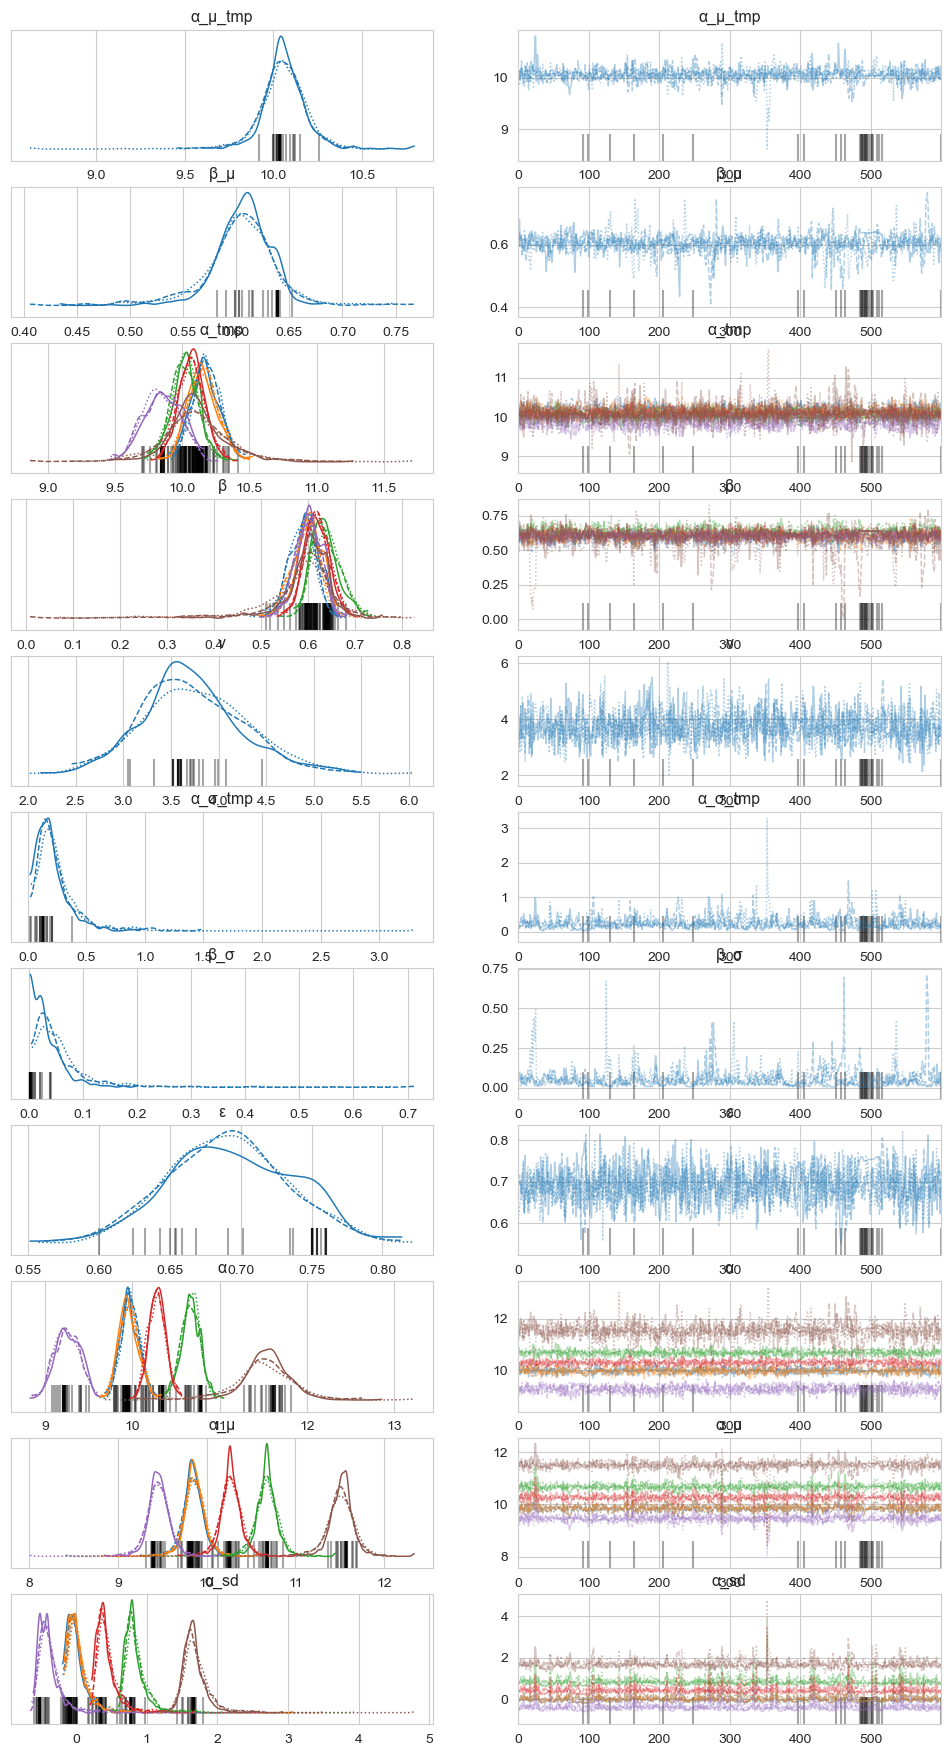

In [10]:
az.plot_trace(trace_hm)

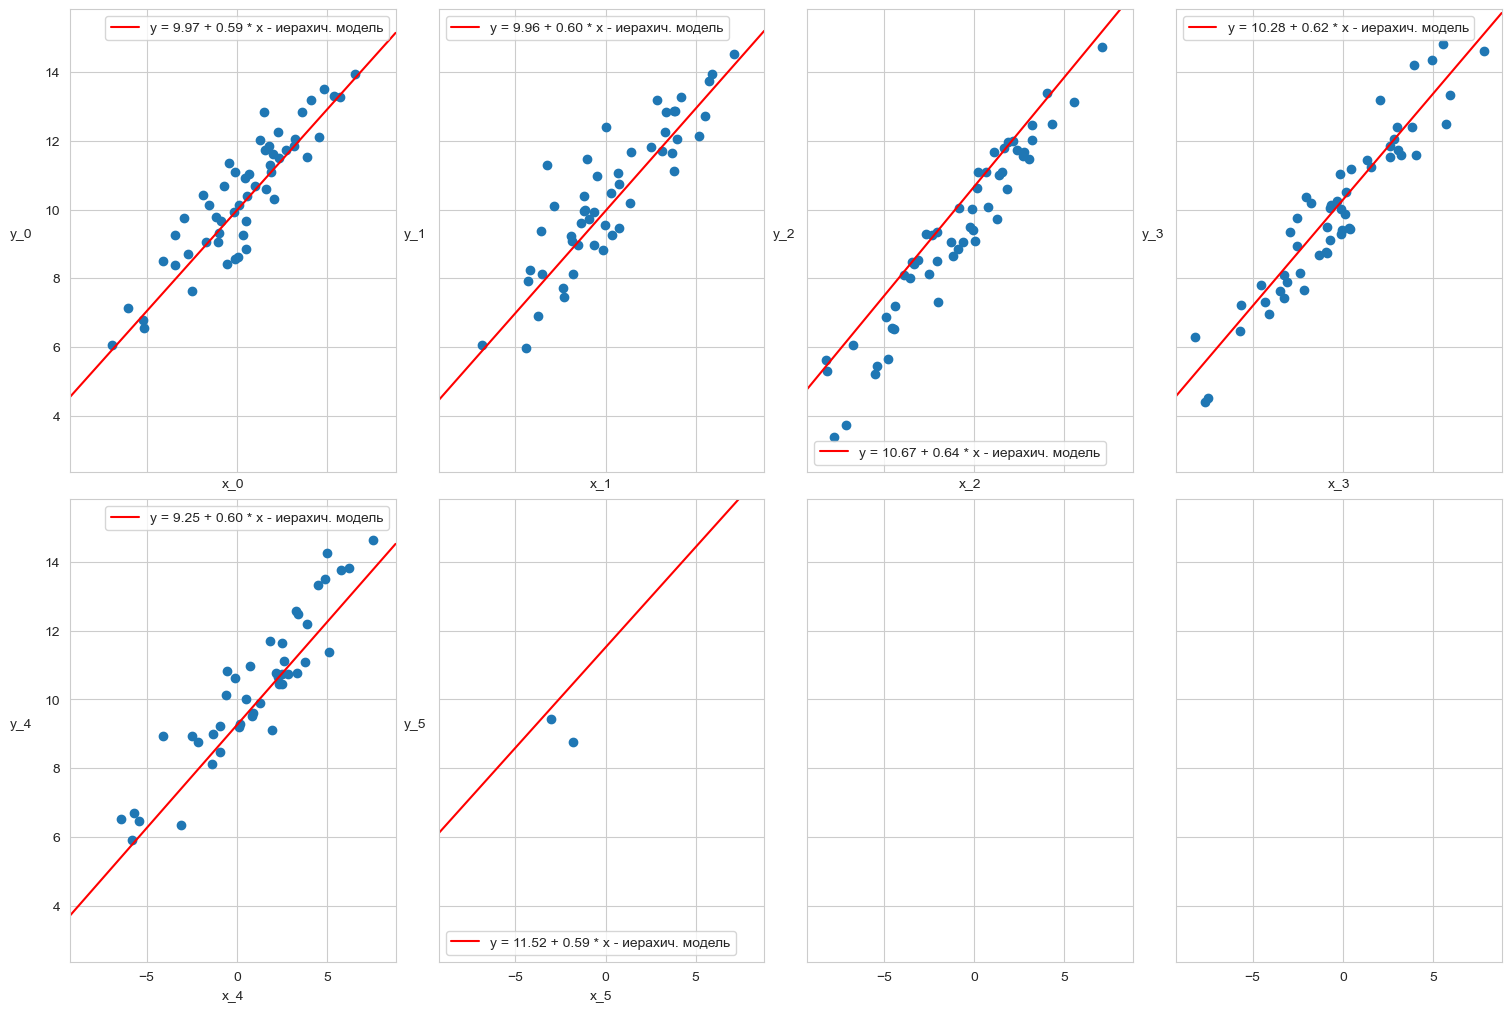

In [11]:
_, ax = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True, constrained_layout=True)

trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})

ax = np.ravel(ax)
j, k = 0, 6
x_range = np.linspace(all_data['x'].min() - 1, all_data['x'].max() + 1, 10)

for i in range(6):
    ax[i].scatter(all_data[all_data['dataset_idx'] == i]['x'], all_data[all_data['dataset_idx'] == i]['y'])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)

    # Получите средние значения параметров из трассировки
    alpha_hmm = trace_hmm['α'].sel({'α_dim_0': i}).mean().item()
    beta_hmm = trace_hmm['β'].sel({'β_dim_0': i}).mean().item()

    ax[i].plot(x_range, alpha_hmm + beta_hmm * x_range, c='r', label=f'y = {alpha_hmm:.2f} + {beta_hmm:.2f} * x' + ' - иерахич. модель')

    ax[i].legend()
    plt.xlim(all_data['x'].min() - 1, all_data['x'].max() + 1)
    plt.ylim(all_data['y'].min() - 1, all_data['y'].max() + 1)